<a href="https://colab.research.google.com/github/Dhanyabahadur/project_notebooks/blob/main/semantic_segmentation_Foodseg103_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [2]:
from datasets import load_dataset

ds = load_dataset("EduardoPacheco/FoodSeg103")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [3]:
from PIL import Image
import numpy as np
import os
ds['train'][0], len(ds['train'])

({'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x384>,
  'classes_on_image': [0, 48, 66, 90],
  'id': 0},
 4983)

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})

In [5]:
ds['train'][0]['classes_on_image']

[0, 48, 66, 90]

In [6]:
# res = []
# for i in classes_on_images:
#   for j in i:
#     if(j not in res):
#       res.append(j)
# res

In [7]:
import os

if not os.path.exists("pytorch_unet.py"):
  if not os.path.exists("pytorch_unet"):
    !git clone https://github.com/usuyama/pytorch-unet.git

  %cd pytorch-unet


import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 67 (delta 6), reused 10 (delta 5), pack-reused 55
Receiving objects: 100% (67/67), 338.19 KiB | 30.74 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/pytorch-unet
device name NVIDIA A100-SXM4-40GB


In [8]:
images = []
masks = []
train_image_dir = 'saved_images_train'
train_mask_dir = 'saved_masks_train'
test_image_dir = 'saved_images_test'
test_mask_dir = 'saved_masks_test'
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)

In [9]:
for i in range(len(ds['train'])):
  row = ds['train'][i]
  image = row['image']
  mask = row['label']
  classes_on_image = row['classes_on_image']
  image_filename = os.path.join(train_image_dir, f'image_{i}.jpg')
  mask_filename = os.path.join(train_mask_dir, f'mask_{i}.jpg')
  image.save(image_filename)
  mask.save(mask_filename)
  # display(image)
  # display(mask)
  #print(f'Label: {mask}, Classes on Image: {classes_on_image}, ID: {id}')

In [10]:
for i in range(len(ds['validation'])):
  row = ds['validation'][i]
  image = row['image']
  mask = row['label']
  image_filename = os.path.join(test_image_dir, f'image_{i}.jpg')
  mask_filename = os.path.join(test_mask_dir, f'mask_{i}.jpg')
  image.save(image_filename)
  mask.save(mask_filename)

In [11]:
from torchvision import transforms

folder_path1 = '/content/pytorch-unet/saved_images_train'
folder_path2 = '/content/pytorch-unet/saved_masks_train'

files1 = sorted(os.listdir(folder_path1))
files2 = sorted(os.listdir(folder_path2))

assert len(files1) == len(files2), "Error"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

image_tensors = []
mask_tensors = []

for filename1, filename2 in zip(files1, files2):
  path1 = os.path.join(folder_path1, filename1)
  path2 = os.path.join(folder_path2, filename2)

  if os.path.isfile(path1) and os.path.isfile(path2):
    img1 = Image.open(path1)#.convert(imread_type)
    img1_tensor = transform(img1)
    image_tensors.append(img1_tensor)
    #print(type(img1))
    #display(img1)
    img2 = Image.open(path2)#.convert(imread_type)
    img2_tensor = transform(img2)
    mask_tensors.append(img2_tensor)
    #print(type(img2))
    #display(img2)

In [12]:
len(image_tensors), len(mask_tensors)
train_image_tensors = image_tensors
train_mask_tensors = mask_tensors

In [13]:
train_image_tensors[0].shape

torch.Size([3, 256, 256])

In [14]:
folder_path1 = '/content/pytorch-unet/saved_images_test'
folder_path2 = '/content/pytorch-unet/saved_masks_test'

files1 = sorted(os.listdir(folder_path1))
files2 = sorted(os.listdir(folder_path2))

assert len(files1) == len(files2), "Error"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

image_tensors = []
mask_tensors = []

for filename1, filename2 in zip(files1, files2):
  path1 = os.path.join(folder_path1, filename1)
  path2 = os.path.join(folder_path2, filename2)

  if os.path.isfile(path1) and os.path.isfile(path2):
    img1 = Image.open(path1)#.convert(imread_type)
    img1_tensor = transform(img1)
    image_tensors.append(img1_tensor)
    img2 = Image.open(path2)#.convert(imread_type)
    img2_tensor = transform(img2)
    mask_tensors.append(img2_tensor)

len(image_tensors), len(mask_tensors)
test_image_tensors = image_tensors
test_mask_tensors = mask_tensors

In [15]:
del(mask_tensors)

In [16]:
del(image_tensors)

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


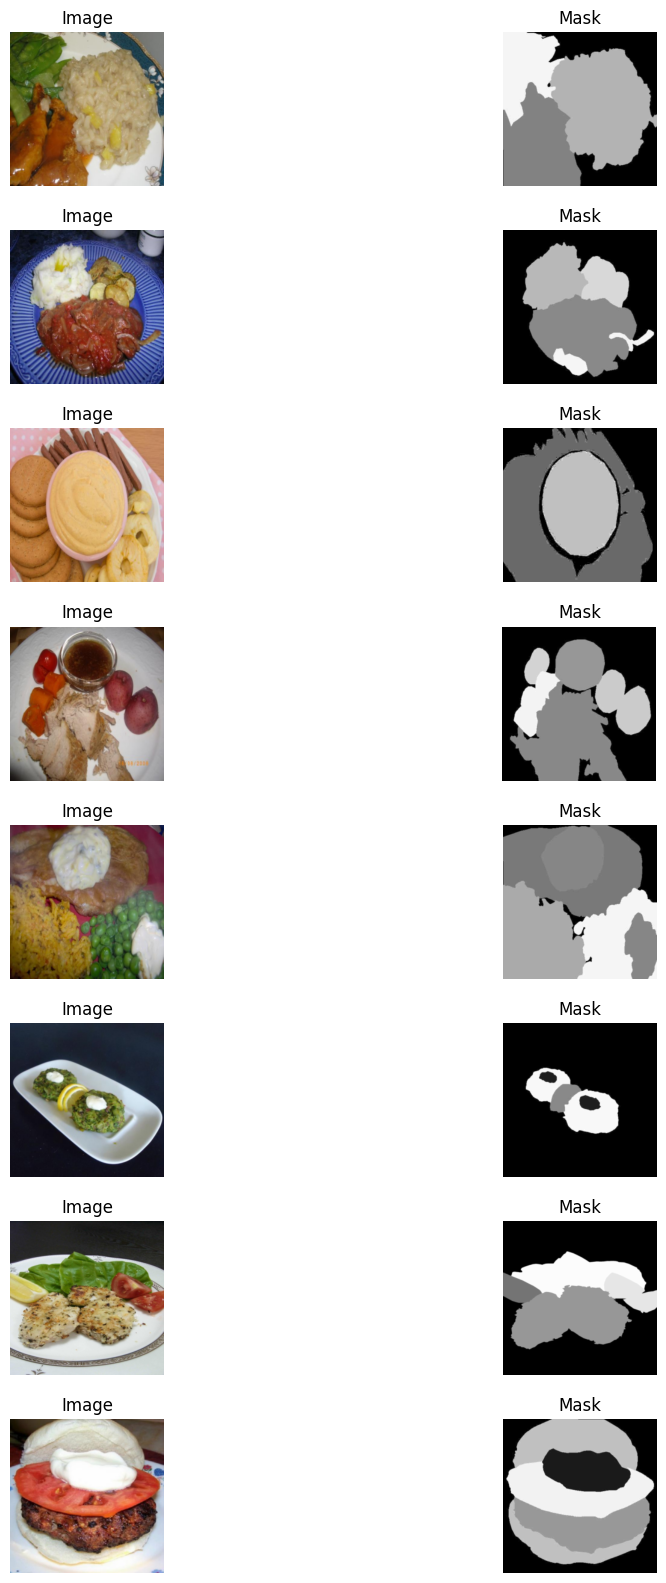

In [24]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Assuming train_image_tensors and train_mask_tensors are lists of tensors
# Convert them to TensorDataset
train_dataset = TensorDataset(torch.stack(train_image_tensors), torch.stack(train_mask_tensors))
test_dataset = TensorDataset(torch.stack(test_image_tensors), torch.stack(test_mask_tensors))

# DataLoader parameters
batch_size = 8

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers = 0),
    'val' : DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
}

# Function to visualize a batch of images and masks
def visualize_batch(dataloaders):
    batch = next(iter(dataloaders['train']))
    images, masks = batch
    print(images.shape, masks.shape)

    fig, axes = plt.subplots(nrows=batch_size, ncols=2, figsize=(10, batch_size * 2))
    fig.tight_layout()

    for i in range(batch_size):
        img = images[i].permute(1, 2, 0)  # CHW to HWC
        mask = masks[i].permute(1, 2, 0)  # CHW to HWC

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    plt.show()

# Visualize a batch from the training dataloader
visualize_batch(dataloaders)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current cuda device: ", torch.cuda.get_device_name(0))

Current cuda device:  NVIDIA A100-SXM4-40GB


In [26]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [27]:
#import pytorch_unet/

model = ResNetUNet(1)
model = model.to(device)

model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [28]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           9,408
            Conv2d-6         [-1, 64, 128, 128]           9,408
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

In [29]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
import time

# download the checkpoint locally
checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
  bce = F.binary_cross_entropy_with_logits(pred, target)

  pred = torch.sigmoid(pred)
  dice = dice_loss(pred, target)

  loss = bce * bce_weight + dice * (1 - bce_weight)

  metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
  metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
  metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

  return loss


def print_metrics(metrics, epoch_samples, phase):
  outputs = []
  for k in metrics.keys():
    outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

  print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs = 25):
  best_loss = 1e10

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    since = time.time()

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode

      metrics = defaultdict(float)
      epoch_samples = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = calc_loss(outputs, labels, metrics)

          # Backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # stats
        epoch_samples += inputs.size(0)

      print_metrics(metrics, epoch_samples, phase)
      epoch_loss = metrics['loss'] / epoch_samples

      if phase == 'train':
        scheduler.step()
        for param_group in optimizer.param_groups:
          print("LR", param_group['lr'])

      # save the model weights
      if phase == 'val' and epoch_loss < best_loss:
        print(f"saving best model to {checkpoint_path}")
        best_loss = epoch_loss
        torch.save(model.state_dict(), checkpoint_path)


    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  print('Best val loss: {:4f}'.format(best_loss))

  # load best model weights
  model.load_state_dict(torch.load(checkpoint_path))
  return model

In [30]:
# Training
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 1
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train: bce: 0.315768, dice: 0.775311, loss: 0.545539
LR 0.0001
val: bce: 0.306206, dice: 0.759641, loss: 0.532923
saving best model to checkpoint.pth
0m 29s
Epoch 1/49
----------
train: bce: 0.299912, dice: 0.752061, loss: 0.525987
LR 0.0001
val: bce: 0.308786, dice: 0.754761, loss: 0.531773
saving best model to checkpoint.pth
0m 29s
Epoch 2/49
----------
train: bce: 0.295053, dice: 0.740507, loss: 0.517780
LR 0.0001
val: bce: 0.314013, dice: 0.752396, loss: 0.533205
0m 29s
Epoch 3/49
----------
train: bce: 0.293313, dice: 0.733861, loss: 0.513587
LR 0.0001
val: bce: 0.302472, dice: 0.763598, loss: 0.533035
0m 29s
Epoch 4/49
----------
train: bce: 0.292690, dice: 0.730244, loss: 0.511467
LR 0.0001
val: bce: 0.317660, dice: 0.742285, loss: 0.529973
saving best model to checkpoint.pth
0m 29s
Epoch 5/49
----------
train: bce: 0.291933, dice: 0.727232, loss: 0.509582
LR 0.0001
val: bce: 0.314720, dice: 0.756852, loss: 0.535786
0m 29s
Epoch 6/49
----------
train: bce: 

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
pred.shape  (8, 1, 256, 256)


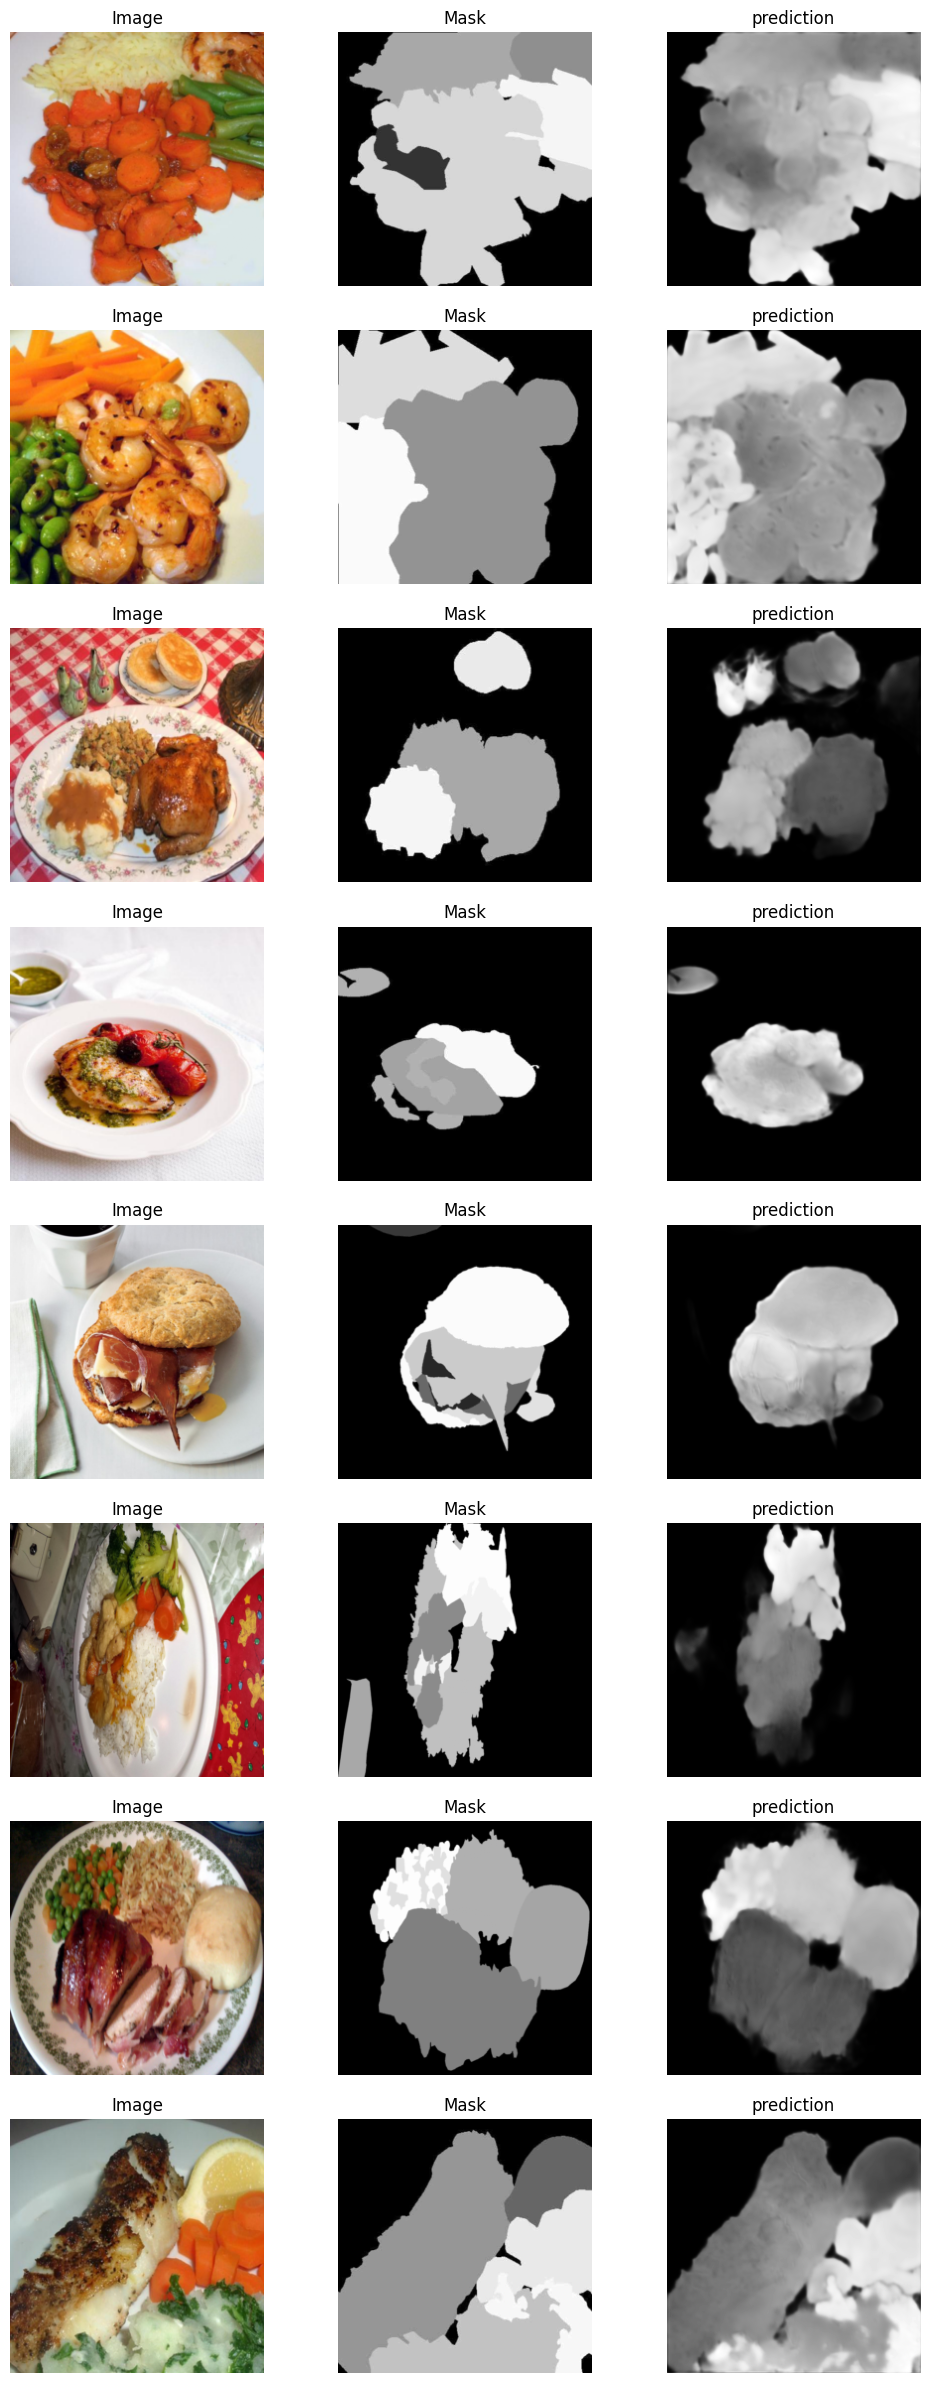

In [49]:
# predict ne wimages using the trained model
import math

model.eval()

test_dataset = TensorDataset(torch.stack(test_image_tensors), torch.stack(test_mask_tensors))

# DataLoader parameters
batch_size = 8

# Create DataLoader instances
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# get the first batch
images, masks = next(iter(test_loader))
images = images.to(device)
masks = masks.to(device)
print(images.shape, masks.shape)

# Predict
with torch.no_grad():
  pred = model(images)
  # The loss functions include the sigmoid function
  pred = torch.sigmoid(pred)
  pred = pred.data.cpu().numpy()
print('pred.shape ', pred.shape)

# Change channel order
fig, axes = plt.subplots(nrows=batch_size, ncols=3, figsize=(10, batch_size * 3))
fig.tight_layout()

for i in range(batch_size):
    img = images[i].permute(1, 2, 0)  # CHW to HWC
    mask = masks[i].permute(1, 2, 0)  # CHW to HWC
    prediction = pred[i].transpose(1, 2, 0)
    #prediction = Image.fromarray((torch.from_numpy(pred[i].astype('uint8')))).permute(1, 2, 0)

    axes[i, 0].imshow(img.cpu())
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask.cpu().squeeze(), cmap='gray')
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(prediction.squeeze(), cmap='gray')
    axes[i, 2].set_title('prediction')
    axes[i, 2].axis('off')


plt.show()